# Scope

Notebook that takes the preprocessed data from the preprocessing notebook and trains a LightGBM model.

The final scope of this notebook is to see what features have the most influence on predicting the price of a listing.

# Import Libraries

In [1]:
import json

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import shap

from sklearn.metrics import r2_score, mean_squared_error

# Load Data

In [2]:
features_dir = Path("data") / "features"

X_train = pd.read_csv(features_dir / "X_train.csv")
X_test = pd.read_csv(features_dir / "X_test.csv")
y_train = pd.read_csv(features_dir / "y_train.csv")
y_test = pd.read_csv(features_dir / "y_test.csv")

with open(features_dir / "meta.json", "r") as f:
    meta = json.load(f)

categorical_features = meta["categorical_features"]

In [3]:
X_train.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,53335715,0.539695,0.0,0.40,0,0,52.36261,4.85446,2,1.0,...,0,0,0,0,0,0,0,0,0,0
1,9282300,0.373401,0.2,0.86,9,9,52.36430,4.88867,2,1.0,...,0,0,0,0,0,0,0,1,1,0
2,16582432,0.423147,1.0,0.71,1,1,52.35396,4.87842,5,3.0,...,0,1,0,0,1,0,0,2,2,0
3,1901477,0.256650,1.0,0.90,1,1,52.37420,4.90401,2,1.0,...,0,1,0,0,1,1,0,1,3,0
4,31540174,0.486904,1.0,1.00,2,2,52.35646,4.88986,4,3.0,...,0,1,0,0,1,1,0,3,1,0


In [4]:
X_test.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,7012495,0.351269,1.00,0.71,0,0,52.36084,4.89542,4,3.0,...,0,1,0,0,1,0,0,1.0,1.0,0
1,19965139,0.436345,1.00,0.80,1,1,52.35984,4.85391,4,1.0,...,0,1,0,0,1,0,0,0.0,1.0,0
2,72558816,0.566904,0.90,0.43,2,2,52.36840,4.86567,2,1.0,...,0,0,0,0,1,0,0,0.0,21.0,0
3,56997633,0.545381,1.00,1.00,3,3,52.38951,4.87912,2,1.0,...,1,0,0,0,1,1,1,34.0,8.0,1
4,85420364,0.580508,0.97,1.00,4,4,52.37106,4.89581,2,1.0,...,0,0,0,0,1,1,1,5.0,8.0,1


In [5]:
categorical_features

['host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'city',
 'has_license',
 'is_bathroom_private',
 'host_verifications_phone',
 'host_verifications_email',
 'host_verifications_jumio',
 'host_verifications_reviews',
 'host_verifications_government_id',
 'amenities_Wifi',
 'amenities_Essentials',
 'amenities_Smoke alarm',
 'amenities_Heating',
 'amenities_Hangers',
 'amenities_Hair dryer',
 'amenities_Hot water',
 'amenities_Kitchen',
 'amenities_Long term stays allowed',
 'amenities_Iron',
 'host_id']

In [6]:
y_train

,price
0,100.0
1,175.0
2,345.0
3,320.0
4,300.0
...,...
5714,94.0
5715,150.0
5716,239.0
5717,78.0


In [7]:
y_test.head()

,price
0,350.0
1,200.0
2,166.0
3,95.0
4,106.0


# Train

In [8]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [
    'country_part',
    'item_category_common',
    'item_category_code',
    'city_code',
]

lgb_train = lgb.Dataset(X_train, y_train)

evals_result = {}
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train],
    categorical_feature=categorical_features,
    verbose_eval=5,
    evals_result=evals_result,
    early_stopping_rounds=20
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
categorical_feature in Dataset is overridden.
New categorical_feature is ['amenities_Essentials', 'amenities_Hair dryer', 'amenities_Hangers', 'amenities_Heating', 'amenities_Hot water', 'amenities_Iron', 'amenities_Kitchen', 'amenities_Long term stays allowed', 'amenities_Smoke alarm', 'amenities_Wifi', 'city', 'has_availability', 'has_license', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_neighbourhood', 'host_response_time', 'host_verifications_email', 'host_verifications_government_id', 'host_verifications_jumio', 'host_verifications_phone', 'host_verifications_reviews', 'instant_bookable', 'is_bathroom_private', 'neighbourhood_cleansed', 'property_type', 'room_type']
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4313
[LightGBM] [Info] Number of data points in the train set: 5719, number of used features: 65
[LightGBM] [Info] Start training from score 162.716034
Training until validation scores don't improve for 20 rounds
[5]	training's rmse: 109.304
[10]	training's rmse: 107.968
[15]	training's rmse: 106.704
[20]	training's rmse: 105.394
[25]	training's rmse: 104.176
[30]	training's rmse: 102.919
[35]	training's rmse: 101.74
[40]	training's rmse: 100.558
[45]	training's rmse: 99.5103
[50]	training's rmse: 98.4283
[55]	training

# Test

In [9]:
y_test_pred = gbm.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"RMSE Score: {mean_squared_error(y_test, y_test_pred, squared=False):.4f}")

R2 Score: 0.5587
RMSE Score: 73.7242


# Plot Feature Importance

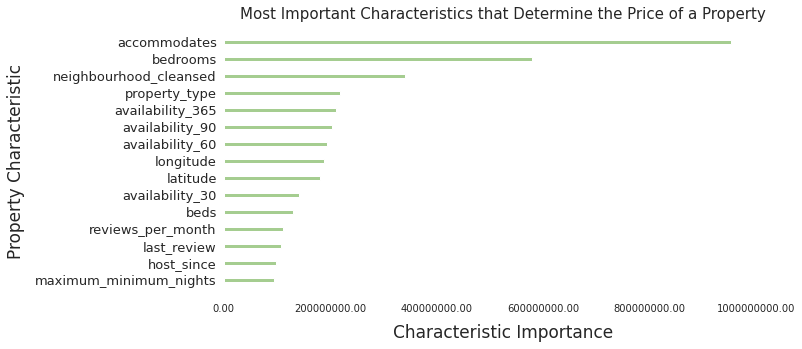

In [10]:
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette("crest", as_cmap=True).colors)

ax = lgb.plot_importance(
    gbm,
    max_num_features=15,
    importance_type='gain',
    figsize=(10,5),

)
ax.set_facecolor("white")

ax.set_xlabel("Characteristic Importance", fontsize=17)
ax.set_ylabel("Property Characteristic", fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=13)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

for txt in ax.texts:
    txt.set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))

plt.title("Most Important Characteristics that Determine the Price of a Property", fontsize=15)
plt.savefig(Path("images") / "lightgbm.png", bbox_inches = "tight")

In [11]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

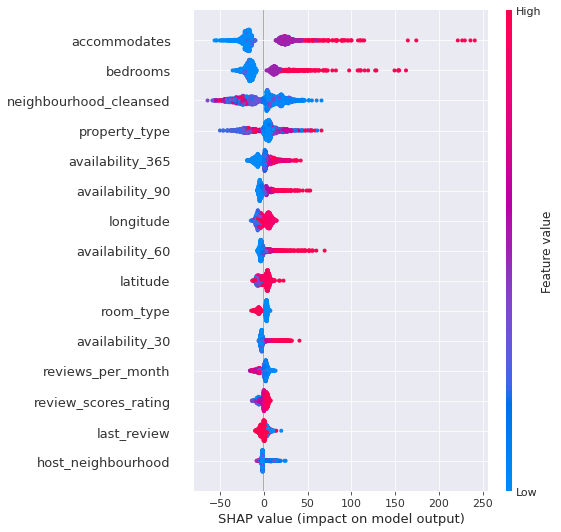

In [12]:
shap.summary_plot(
    shap_values,
    X_test,
    max_display=15,
    title="Most Important Characteristics that Determine the Price of a Property"
)